In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import cv2

plt.rcParams['font.size'] = 18

In [2]:
class InputToCx(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(InputToCx, self).__init__()
        self.output_dim = output_dim

    def call(self, inputs, **kwargs):
        real = inputs * tf.cos(0.0)
        imag = inputs * tf.sin(0.0)
        return tf.stack([real, imag], axis=1)

In [3]:
class CxMO(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxMO, self).__init__()
        self.output_dim = output_dim

    # input[0,:,:] = real
    # input[1,:,:] = image
    def build(self, input_dim):
        self.phi = self.add_variable("phi",
                                     shape=[int(input_dim[-2]),
                                            int(input_dim[-1])])

        super(CxMO, self).build(input_dim)

    def call(self, x):
        x_real = Lambda(lambda x: x[: ,0, :, :], output_shape=self.output_dim)(x)  # real
        x_imag = Lambda(lambda x: x[: ,1, :, :], output_shape=self.output_dim)(x)  # imag
        mo_real = tf.cos(self.phi)
        mo_imag = tf.sin(self.phi)

        real = x_real * mo_real - x_imag * mo_imag
        imag = x_real * mo_imag + x_imag * mo_real
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx

In [4]:
class FreeSpacePropagation(tf.keras.layers.Layer):
    def __init__(self, output_dim, k, z, input_pitch=1e-6, output_pitch=1e-6):
        super(FreeSpacePropagation, self).__init__()
        self.output_dim = output_dim
        self.input_pitch = input_pitch
        self.output_pitch = output_pitch
        self.z = z
        self.k = k

    def build(self, input_shape):

        x1 = np.arange(0, input_shape[-1], 1)
        y1 = np.arange(0, input_shape[-2], 1)
        xx1, yy1 = np.meshgrid(x1, y1)
        xx1 = xx1.reshape(-1, 1) - input_shape[-1]/2
        yy1 = yy1.reshape(-1, 1) - input_shape[-2]/2

        x2 = np.arange(0, self.output_dim[1], 1)
        y2 = np.arange(0, self.output_dim[0], 1)
        xx2, yy2 = np.meshgrid(x2, y2)
        xx2 = xx2.reshape(1, -1) - self.output_dim[1]/2
        yy2 = yy2.reshape(1, -1) - self.output_dim[0]/2

        dx = (self.output_pitch * xx2 - self.input_pitch * xx1)
        dy = (self.output_pitch * yy2 - self.input_pitch * yy1)
        r = np.sqrt(dx**2 + dy**2 + self.z**2)
        w = 1/(2*np.pi) * self.z / r * (1/r - 1j*self.k) * np.exp(1j * self.k * r)

        self.w_real = tf.Variable(initial_value=w.real.astype('float32'),
                                              trainable=False)
        self.w_imag = tf.Variable(initial_value=w.imag.astype('float32'),
                                              trainable=False)

        super(FreeSpacePropagation, self).build(input_shape)

    def call(self, x, **kwargs):
        x_real = Lambda(lambda x: x[:,0, :, :], output_shape=(self.output_dim,))(x)  # real
        x_imag = Lambda(lambda x: x[:,1, :, :], output_shape=(self.output_dim,))(x)  # imag
        x_real = tf.reshape(x_real, (-1, x.shape[-1]*x.shape[-2]))
        x_imag = tf.reshape(x_imag, (-1, x.shape[-1]*x.shape[-2]))
        real = tf.matmul(x_real, self.w_real) - tf.matmul(x_imag, self.w_imag)
        imag = tf.matmul(x_imag, self.w_real) + tf.matmul(x_real, self.w_imag)
        real = tf.reshape(real, (-1, self.output_dim[0], self.output_dim[1]))
        imag = tf.reshape(imag, (-1, self.output_dim[0], self.output_dim[1]))
        cmpx = tf.stack([real, imag], axis=1)
        return cmpx


In [5]:
class CxD2NNMNISTDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super(CxD2NNMNISTDetector, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.input_dim = input_shape
        self.width = int(tf.floor(self.input_dim[2]/4.0))
        self.height = int(tf.floor(self.input_dim[1]/3.0))
        super(CxD2NNMNISTDetector, self).build(input_shape)

    def plot_area(self, input_shape):
        width = int(tf.floor(input_shape[1]/4.0))
        height = int(tf.floor(input_shape[0]/3.0))
        x = np.zeros(input_shape)
        x[0:height-1, 0:width-1] = 1
        x[0:height-1, width:width*2-1] = 2
        x[0:height-1, width*2:width*3-1] = 3
        x[height:height*2-1, 0:width-1] = 4
        x[height:height*2-1, width:width*2-1] = 5
        x[height:height*2-1, width*2:width*3-1] = 6
        x[height:height*2-1, width*3:width*4-1] = 7
        x[height*2:height*3-1, 0:width-1] = 8
        x[height*2:height*3-1, width:width*2-1] = 9
        x[height*2:height*3-1, width*2:width*3-1] = 10
        plt.imshow(x)

    def call(self, x, **kwargs):
        y0 = x[:, 0:self.height-1, 0:self.width-1]
        y1 = x[:, 0:self.height-1, self.width:self.width*2-1]
        y2 = x[:, 0:self.height-1, self.width*2:self.width*3-1]
        y3 = x[:, self.height:self.height*2-1, 0:self.width-1]
        y4 = x[:, self.height:self.height*2-1, self.width:self.width*2-1]
        y5 = x[:, self.height:self.height*2-1, self.width*2:self.width*3-1]
        y6 = x[:, self.height:self.height*2-1, self.width*3:self.width*4-1]
        y7 = x[:, self.height*2:self.height*3-1, 0:self.width-1]
        y8 = x[:, self.height*2:self.height*3-1, self.width:self.width*2-1]
        y9 = x[:, self.height*2:self.height*3-1, self.width*2:self.width*3-1]
        y0 = tf.reduce_sum(y0, axis=[1])
        y0 = tf.reduce_sum(y0, axis=[1], keepdims=True)
        y1 = tf.reduce_sum(y1, axis=[1])
        y1 = tf.reduce_sum(y1, axis=[1], keepdims=True)
        y2 = tf.reduce_sum(y2, axis=[1])
        y2 = tf.reduce_sum(y2, axis=[1], keepdims=True)
        y3 = tf.reduce_sum(y3, axis=[1])
        y3 = tf.reduce_sum(y3, axis=[1], keepdims=True)
        y4 = tf.reduce_sum(y4, axis=[1])
        y4 = tf.reduce_sum(y4, axis=[1], keepdims=True)
        y5 = tf.reduce_sum(y5, axis=[1])
        y5 = tf.reduce_sum(y5, axis=[1], keepdims=True)
        y6 = tf.reduce_sum(y6, axis=[1])
        y6 = tf.reduce_sum(y6, axis=[1], keepdims=True)
        y7 = tf.reduce_sum(y7, axis=[1])
        y7 = tf.reduce_sum(y7, axis=[1], keepdims=True)
        y8 = tf.reduce_sum(y8, axis=[1])
        y8 = tf.reduce_sum(y8, axis=[1], keepdims=True)
        y9 = tf.reduce_sum(y9, axis=[1])
        y9 = tf.reduce_sum(y9, axis=[1], keepdims=True)
        y = tf.keras.layers.concatenate([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9])

        if self.activation == 'softmax':
            y = tf.nn.softmax(y)
        return y

In [6]:
class CxD2NNIntensity(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization='min_max', **kwargs):
        super(CxD2NNIntensity, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.normalization = normalization

    def call(self, x, **kwargs):
        real = Lambda(lambda x: x[:, 0, :, :])(x)
        image = Lambda(lambda x: x[:, 1, :, :])(x)
        intensity = tf.sqrt(real ** 2 + image ** 2)
        if self.normalization == 'min_max':
            max = tf.reduce_max(intensity)
            min = tf.reduce_min(intensity)
            intensity = (intensity - min)/(max - min)
        if self.normalization == 'max':
            max = tf.reduce_max(intensity)
            intensity = intensity / max

        return intensity

In [7]:
class MOD2NN(tf.keras.Model):
    def __init__(self):
        super(MOD2NN, self).__init__()
        self.l = 633e-9
        self.k = 2 * np.pi / self.l
        self.d = 1e-6
        self.mo1 = CxMO((28, 28))
        self.propag1 = FreeSpacePropagation((28, 28), self.d, 2e-3, self.k)
        self.mo2 = CxMO((28, 28))
        self.prooag2 = FreeSpacePropagation((1, 10), self.d*2, 1e-9, self.k)

    def call(self, x):
        x = self.mo1(inputs)
        x = self.propag1(x)
        x = self.mo2(x)
        x = self.prooag2(x)
        x = tf.nn.softmax(x[0,:,:])

        return x

In [17]:
mnist = tf.keras.datasets.mnist

image_shape = (28, 28)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_train)))
x_test = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_test)))
#y_train = np.array(list(map(lambda y_label : y_images[y_label], y_train)))
#y_test = np.array(list(map(lambda y_label : y_images[y_label], y_test)))
x_train = x_train/255.0
x_test = x_test/255.0

(10, 28, 28)


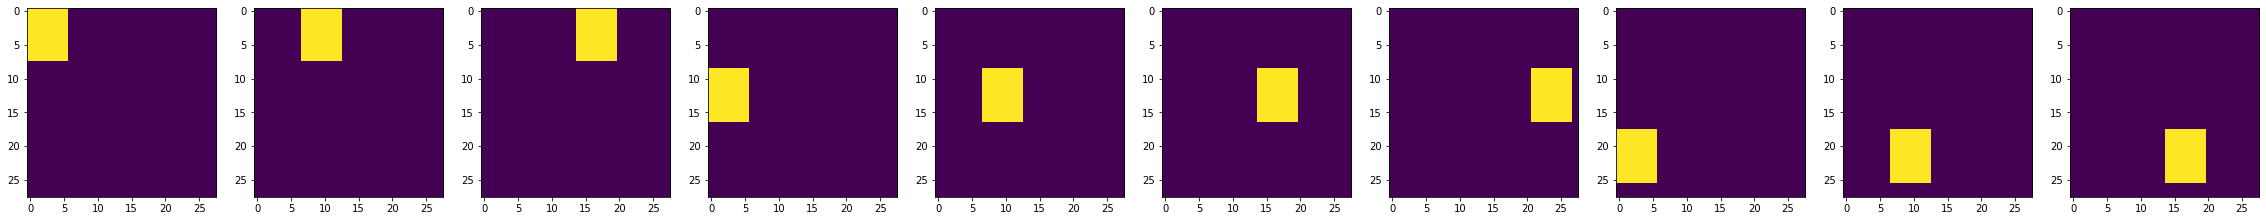

In [18]:
y_images = []
width = int(tf.floor(image_shape[1]/4.0))
height = int(tf.floor(image_shape[0]/3.0))
x = np.zeros(image_shape)
y0 = x.copy()
y0[0:height-1, 0:width-1] = 1
y_images.append(y0)
y1 = x.copy()
y1[0:height-1, width:width*2-1] = 1
y_images.append(y1)
y2 = x.copy()
y2[0:height-1, width*2:width*3-1] = 1
y_images.append(y2)
y3 = x.copy()
y3[height:height*2-1, 0:width-1] = 1
y_images.append(y3)
y4 = x.copy()
y4[height:height*2-1, width:width*2-1] = 1
y_images.append(y4)
y5 = x.copy()
y5[height:height*2-1, width*2:width*3-1] = 1
y_images.append(y5)
y6 = x.copy()
y6[height:height*2-1, width*3:width*4-1] = 1
y_images.append(y6)
y7 = x.copy()
y7[height*2:height*3-1, 0:width-1] = 1
y_images.append(y7)
y8 = x.copy()
y8[height*2:height*3-1, width:width*2-1] = 1
y_images.append(y8)
y9 = x.copy()
y9[height*2:height*3-1, width*2:width*3-1] = 1
y_images.append(y9)
y_images = tf.constant(y_images)
print(y_images.shape)
fig, axes = plt.subplots(1, 10, figsize=(40,4))
for i, ax in enumerate(axes):
  ax.imshow(y_images[i,:,:])

def loss_ms(y_hat, y):
  return tf.losses.mean_squared_error(y_hat, y)

In [19]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)

In [20]:
l = 633e-9
k = 2 * np.pi / l
d = 1e-6


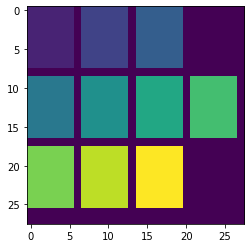

In [21]:
detector = CxD2NNMNISTDetector(10)
detector.plot_area(image_shape)

In [73]:
inputs = keras.Input(image_shape)
x = InputToCx(image_shape)(inputs)
x = CxMO(image_shape)(x)
x = FreeSpacePropagation(image_shape, k, 0.5e-3)(x)
x = CxD2NNIntensity(image_shape, normalization='max')(x)
x = CxD2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam', 
              loss="sparse_categorical_crossentropy",   # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 10
early_stopping =  EarlyStopping(
                            monitor='accuracy',
                            min_delta=0.05,
                            patience=2,
)

result = model.fit(x_train, 
                   y_train, 
                   batch_size=64, 
                   epochs=epochs
                   #callbacks=[early_stopping]
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  # This is added back by InteractiveShellApp.init_path()


Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 input_to_cx_8 (InputToCx)   (None, 2, 28, 28)         0         
                                                                 
 cx_mo_14 (CxMO)             (None, 2, 28, 28)         784       
                                                                 
 free_space_propagation_14 (  (None, 2, 28, 28)        1229312   
 FreeSpacePropagation)                                           
                                                                 
 cx_d2nn_intensity_8 (CxD2NN  (None, 28, 28)           0         
 Intensity)                                                      
                                                                 
 cx_d2nnmnist_detector_12 (C  (None, 10)               0  

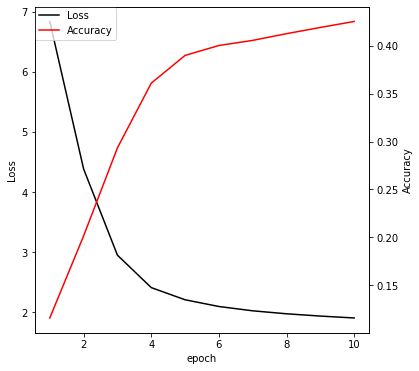

In [74]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, epochs + 1), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

array([[6.3260647e-12, 5.1789823e-20, 2.1169969e-10, 1.6238576e-10,
        9.9999976e-01, 9.6797451e-13, 1.8117257e-08, 1.1226368e-08,
        4.5148130e-12, 2.3807884e-07]], dtype=float32)

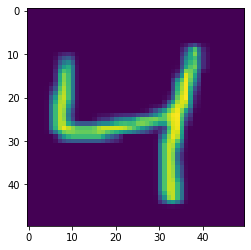

In [ ]:
plt.imshow(x_train[2,:,:])
out = model.predict(np.array([x_train[2,:,:]]))
out

In [75]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden_layer_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 input_to_cx_8 (InputToCx)   (None, 2, 28, 28)         0         
                                                                 
 cx_mo_14 (CxMO)             (None, 2, 28, 28)         784       
                                                                 
 free_space_propagation_14 (  (None, 2, 28, 28)        1229312   
 FreeSpacePropagation)                                           
                                                                 
 cx_d2nn_intensity_8 (CxD2NN  (None, 28, 28)           0         
 Intensity)                                                      
                                                                 
Total params: 1,230,096
Trainable params: 784
Non-trainabl

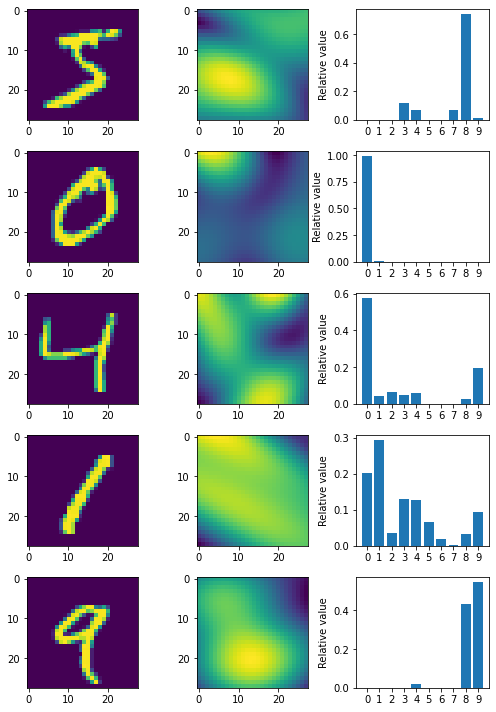

In [76]:
num = 5
images = x_train[0:num,:,:]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
fig, axes = plt.subplots(num, 3, figsize=(7,10))
for i in range(num):
  axes[i,0].imshow(images[i,:,:])
  axes[i,1].imshow(pred_images[i, :, :])
  axes[i,2].bar(np.arange(0, 10, 1), preds[i,:], align='center')
  axes[i,2].set_xticks(np.arange(0, 10, 1))
  axes[i,2].set_ylabel('Relative value')
fig.tight_layout()

In [77]:
test_inputs = keras.Input(image_shape)
test_x = CxD2NNMNISTDetector(10, activation='softmax')(test_inputs)
test_model = tf.keras.Model(test_inputs, test_x)

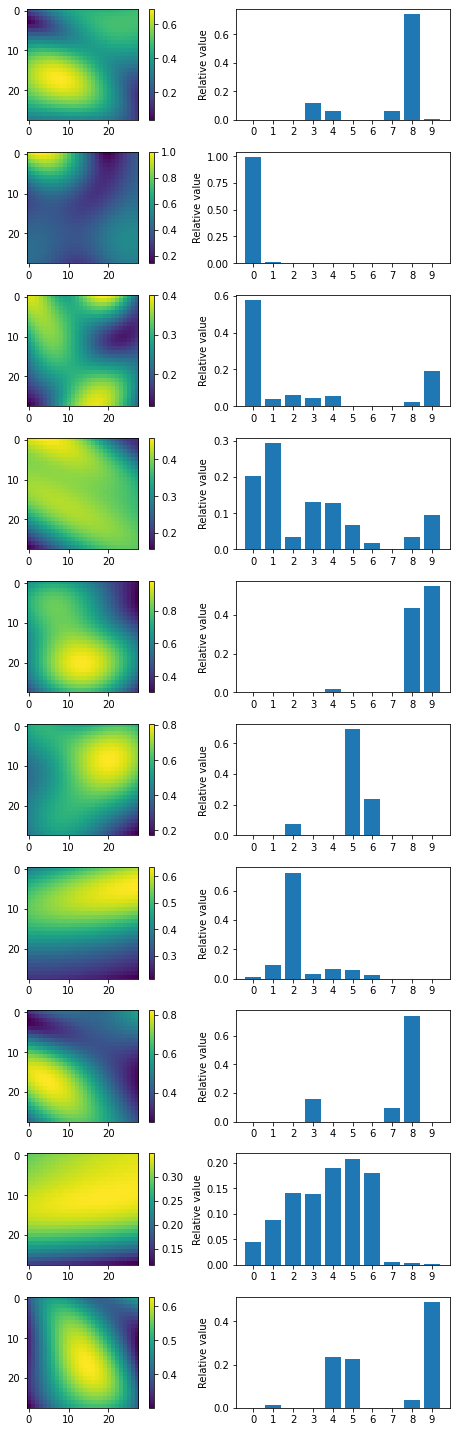

In [78]:
num = 10
pred_images = hidden_layer_model.predict(x_train[:num, :, :])
test_preds = test_model.predict(pred_images)
fig, axes = plt.subplots(num, 2, figsize=(7,20))
for i in range(num):
  _im = axes[i,0].imshow(pred_images[i,:,:])
  fig.colorbar(_im, ax=axes[i,0])
  axes[i,1].bar(np.arange(0, 10, 1), test_preds[i,:], align='center')
  axes[i,1].set_xticks(np.arange(0, 10, 1))
  axes[i,1].set_ylabel('Relative value')
fig.tight_layout()